<h1 align="center">CLEANING DATA</h1>

## Giới thiệu về bộ dữ liệu sẽ xử lý

- Bộ dữ liệu raw bao gồm 4 file `laptop_basic.csv`, `laptop_detail.csv`, `cpuben.csv` và `cpuben.csv`. Dữ liệu được cào từ website [LaptopMedia](https://laptopmedia.com/)
- File `laptop_basic.csv` chứa link thông tin của 1000 laptop.
- File `laptop_detail.csv` chứa thông tin chi tiết của 1000 laptop.
- File `cpuben.csv` chứa thông tin benchmark và thứ hạng hiệu năng của 122 mẫu CPU.
- File `gpuben.csv` chứa thông tin benchmark và thứ hạng hiệu năng của 140 mẫu GPU.
- Trong notebook này, chúng em sẽ tiến hành gộp, xử lý và làm sạch dữ liệu. Kết quả cuối cùng sẽ được lưu vào file 'clean_data.csv' 

## 1. Khai báo thư viện


In [1]:
import numpy as np
import pandas as pd
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

## 2. Load và kiểm tra tập dữ liệu thô

In [2]:
data_detail = pd.read_csv('raw1k\laptop_detail.csv')
print('Number of rows and columns:', data_detail.shape)

Number of rows and columns: (1000, 42)


In [3]:
data_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 42 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Unnamed: 0.1                                                 1000 non-null   int64  
 1   Unnamed: 0                                                   1000 non-null   int64  
 2   Product Name                                                 1000 non-null   object 
 3   Product Link                                                 1000 non-null   object 
 4   Processor                                                    1000 non-null   object 
 5   Internal memory                                              1000 non-null   object 
 6   Video card                                                   1000 non-null   object 
 7   Display                                                      998 non-null    ob

In [4]:
data_detail.head(3)

,Unnamed: 0.1,Unnamed: 0,Product Name,Product Link,Processor,Internal memory,Video card,Display,Solid-state drive,Price,...,MIL-STD-810G military certification,"14"" ScreenPad Plus (3840 x 1100, IPS, with stylus support)\n","14"" ScreenPad Plus (1920 x 550, IPS, with stylus support)",Accelerometer\n,Gyroscope\n,eCompass,Compartment for Wireless Earbuds,Battery gauge button and indicator,Ambient light sensor\n,Force Touch trackpad
0,0,0,ASUS ROG Zephyrus G14,https://laptopmedia.com/laptop-specs/asus-rog-...,AMD Ryzen 9 5900HS,24GB RAM,"NVIDIA GeForce RTX 3050 Ti (Laptop, 75W)","14.0″, WQHD (2560 x 1440), 120 Hz, IPS",1000GB SSD,$155900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Lenovo ThinkPad T16 Gen 1,https://laptopmedia.com/laptop-specs/lenovo-th...,Intel Core i7-1260P,16GB RAM,Intel Iris Xe Graphics G7 (96EU),"16.0”, WUXGA (1920 x 1200), IPS",512GB SSD,$116995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,HP 15,https://laptopmedia.com/laptop-specs/hp-15-14999/,Intel Core i7-1165G7,32GB RAM,Intel Iris Xe Graphics G7 (96EU),"15.6”, Full HD (1920 x 1080), IPS",1000GB SSD,$114900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
col_nan_count = data_detail.isnull().sum()
# count number of columns with missing values
print('Number of columns with missing values:', len(col_nan_count[col_nan_count > 0]))

Number of columns with missing values: 28


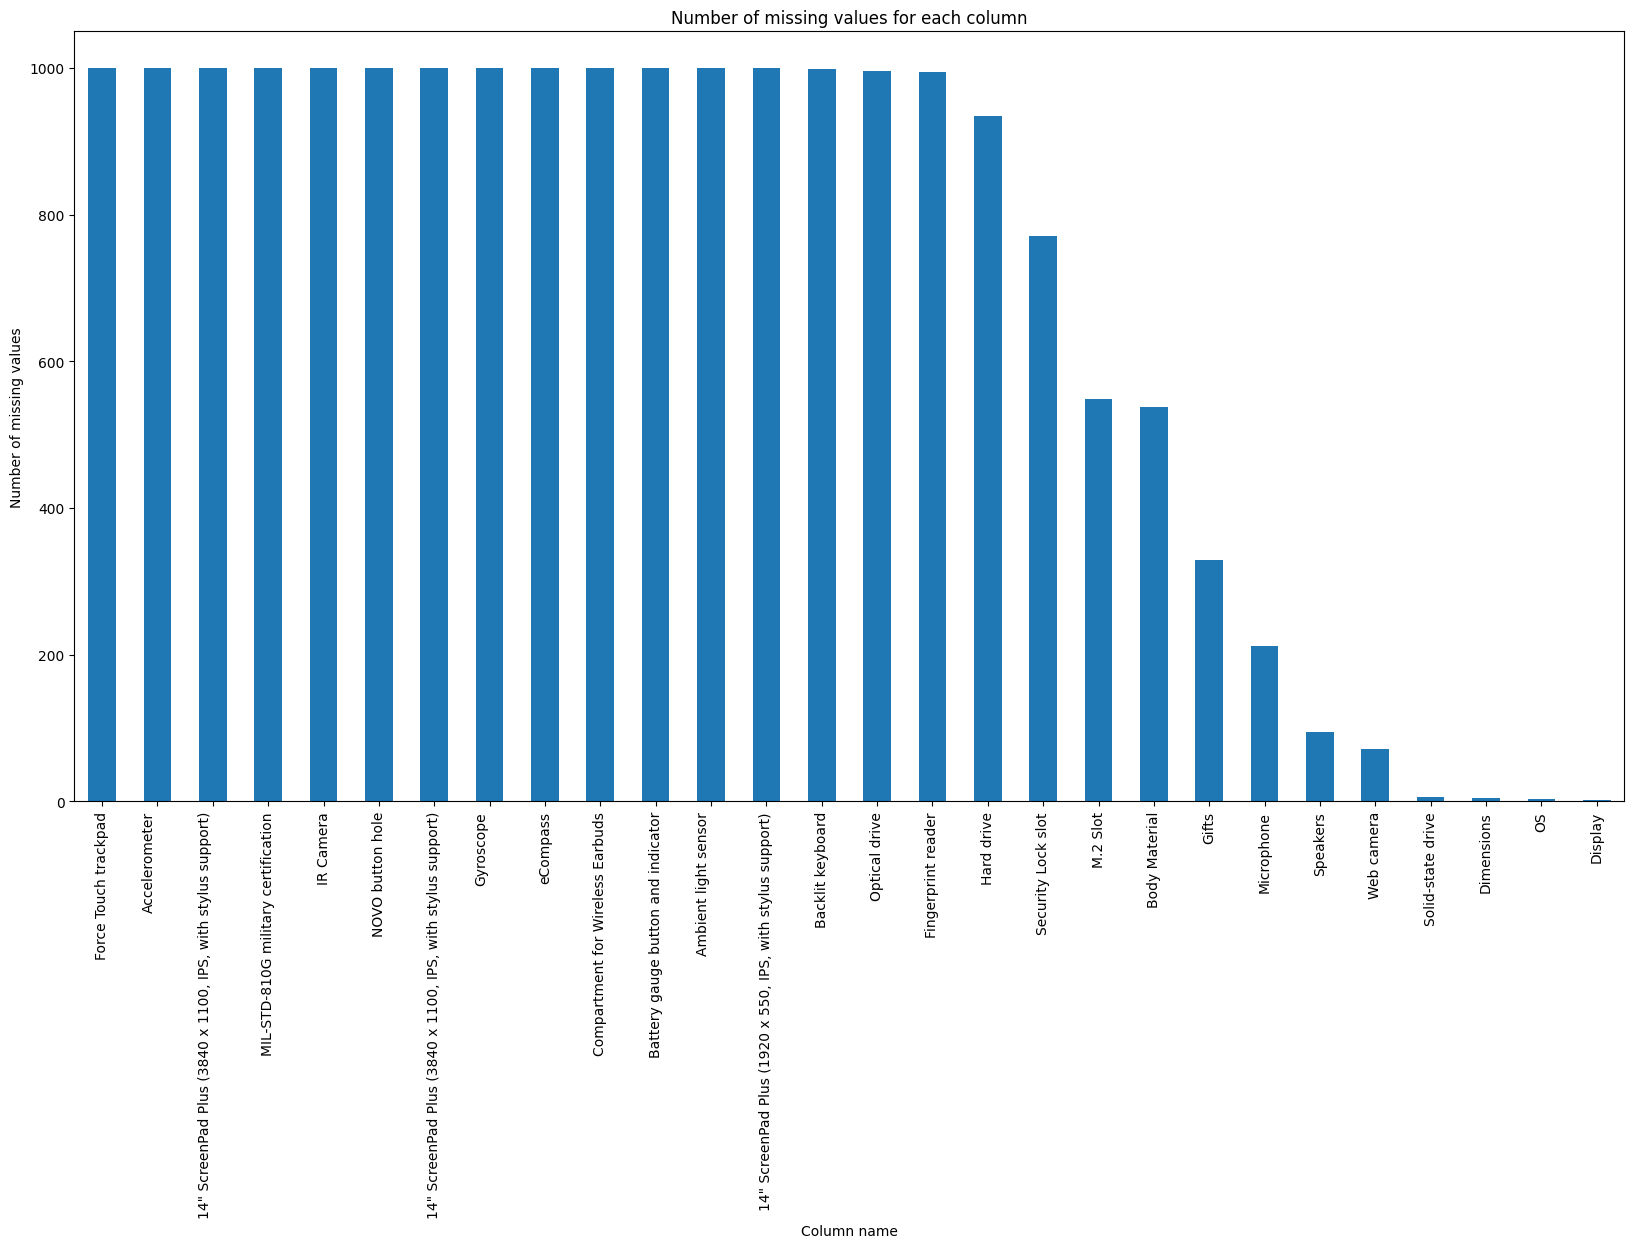

In [6]:
# plot number of missing values for each column with x axis is column name and y axis is number of missing values and sort by number of missing values
col_nan_count[col_nan_count > 0].sort_values(ascending=False).plot(kind='bar', figsize=(20, 10))
plt.title('Number of missing values for each column')
plt.xlabel('Column name')
plt.ylabel('Number of missing values')
plt.show()

## 3. Làm sạch dữ liệu

### 3.1 Xóa hai cột thông tin dư đầu tiên
Hai cột đầu tiên không chứa thông tin liên quan nên sẽ được xóa bỏ.

In [7]:
# delete the first two column
data_detail = data_detail.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

### 3.2 Xử lý dữ liệu trống, trùng lặp và không cần thiết


#### 3.2.1 Kiểm tra lại tập dữ liệu


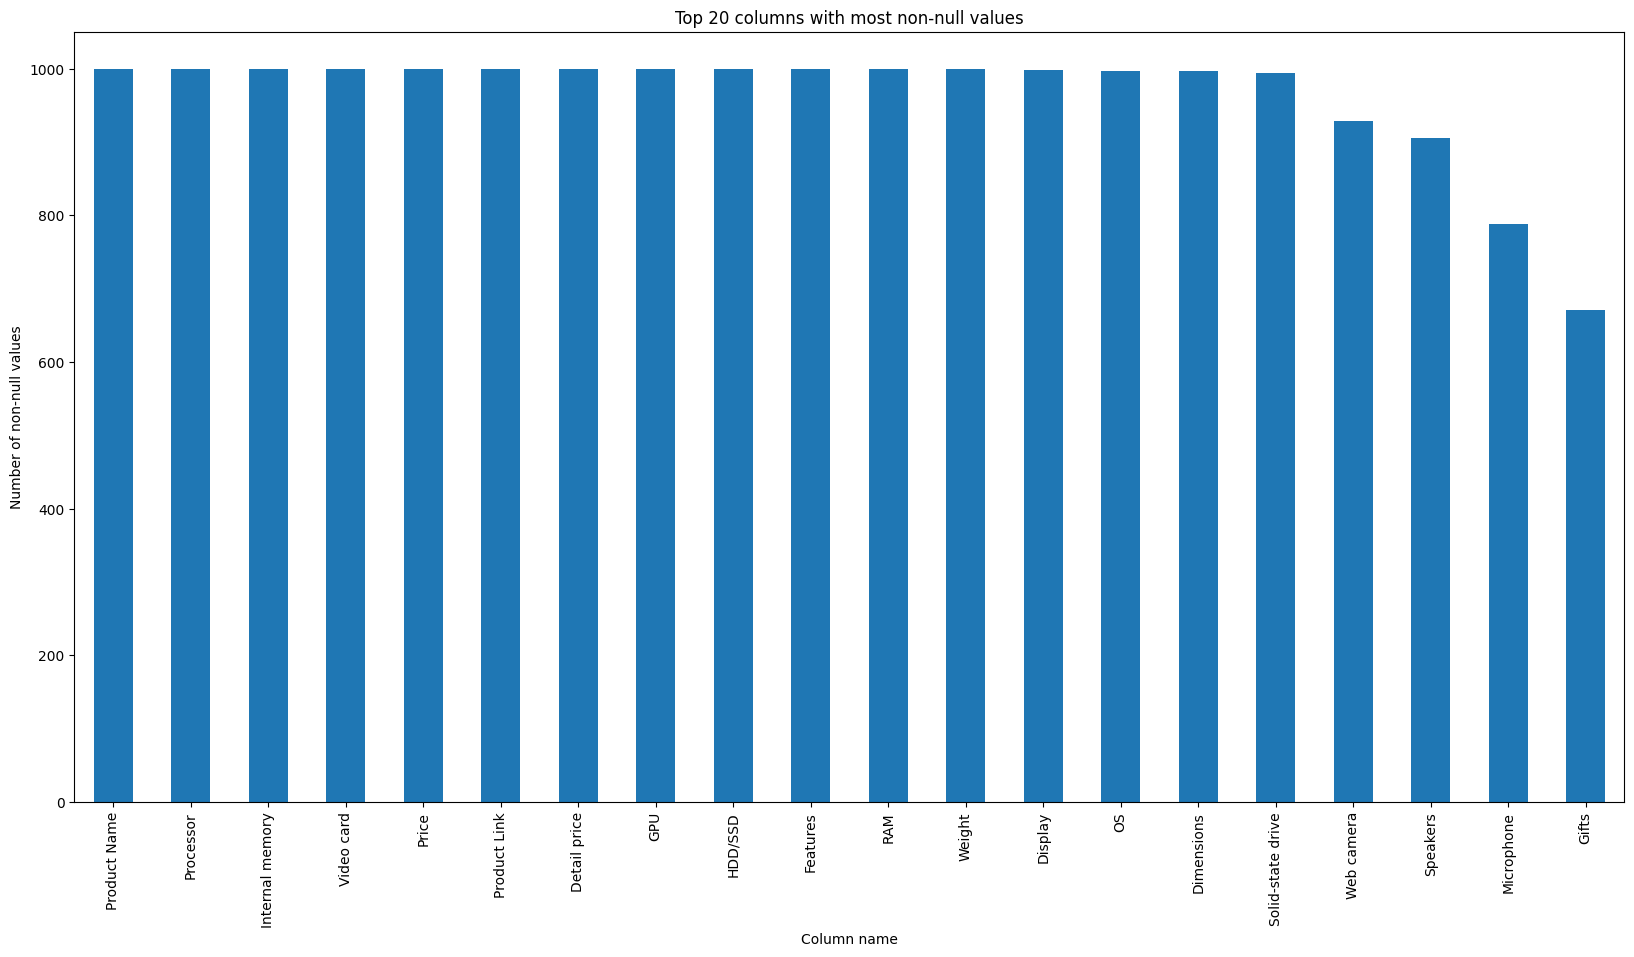

In [8]:
# plot top 20 columns with most non-null values
data_detail.count().sort_values(ascending=False)[:20].plot(kind='bar', figsize=(20, 10))
plt.title('Top 20 columns with most non-null values')
plt.xlabel('Column name')
plt.ylabel('Number of non-null values')
plt.show()

#### 3.2.2 Xóa các cột thông tin chứa quá nhiều dữ liệu trống


- Xóa các cột mà trong đó số giá trị null chiếm hơn 20% tổng số giá trị của cột đó.

In [9]:
def filter_column_meaningless(df, percent=0.80):
    filtered_column = []
    for column in df.columns:
        if (df[column].notnull().sum() <= percent * df.shape[0]):
            filtered_column.append(column)
    return filtered_column

In [10]:
useless_column = filter_column_meaningless(data_detail)

22


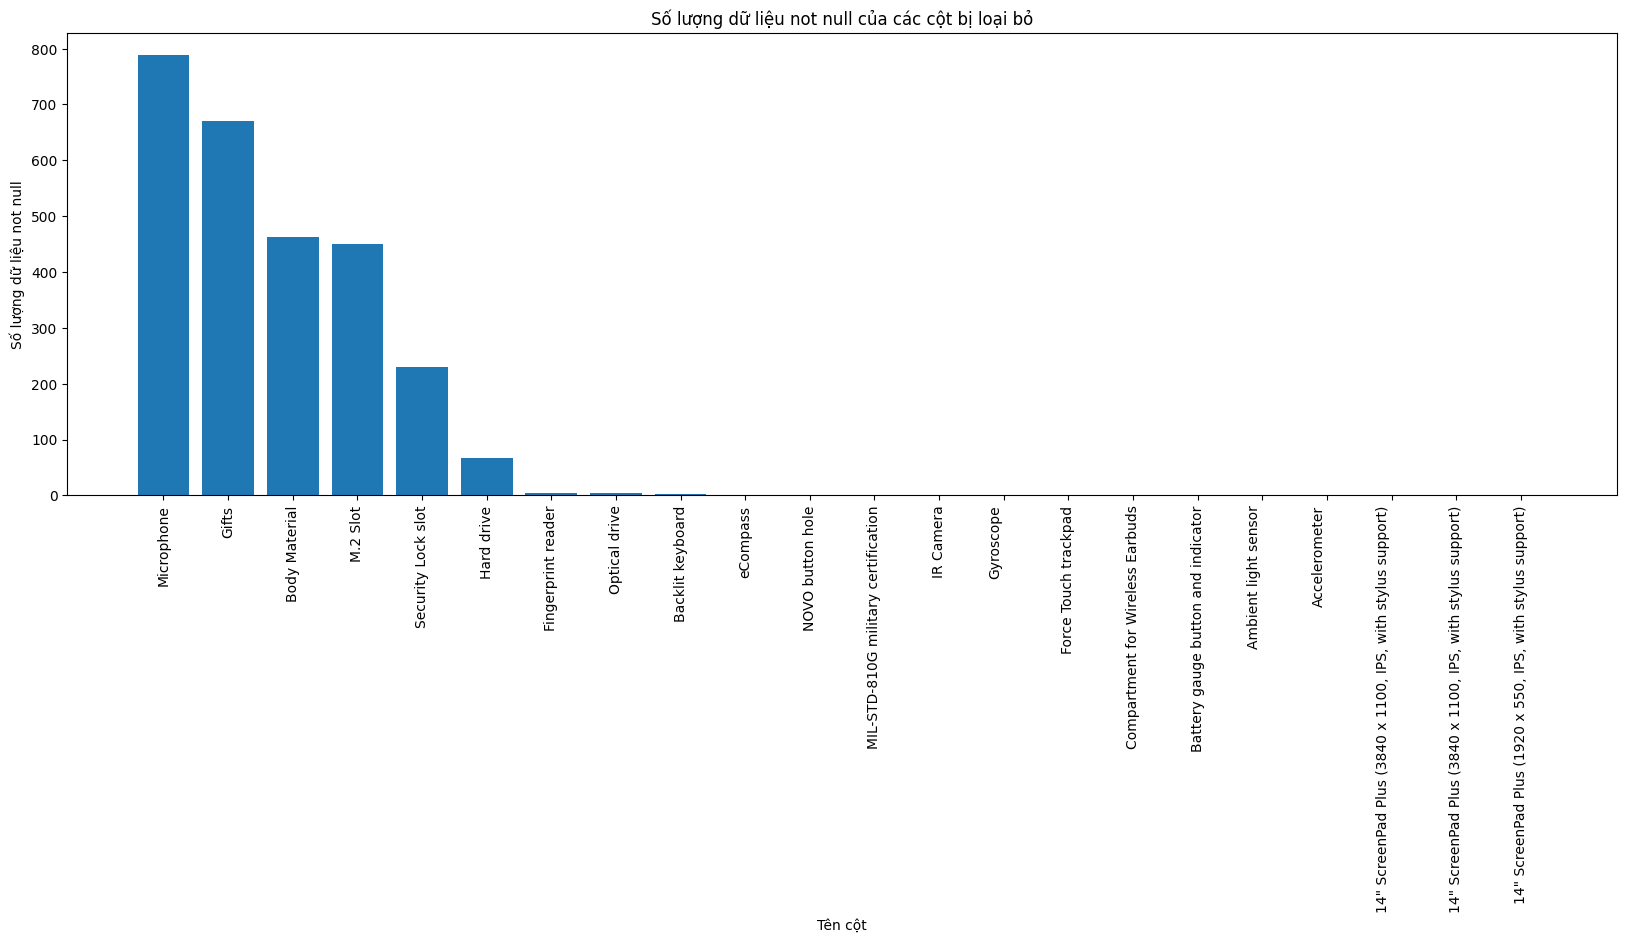

In [11]:
# print the name and number of non-null values of useless columns
print(len(useless_column))
useless_column_count = []
for column in useless_column:
    useless_column_count.append(data_detail[column].notnull().sum())

# sort the number of non-null values of useless columns
useless_column_count, useless_column = zip(*sorted(zip(useless_column_count, useless_column), reverse=True))

# plot on bar chart
plt.figure(figsize=(20, 6 ))
plt.bar(useless_column, useless_column_count)
plt.xticks(rotation=90)
plt.title('Số lượng dữ liệu not null của các cột bị loại bỏ')
plt.xlabel('Tên cột')
plt.ylabel('Số lượng dữ liệu not null')
plt.show()

In [12]:

data = data_detail.drop(columns=filter_column_meaningless(data_detail))

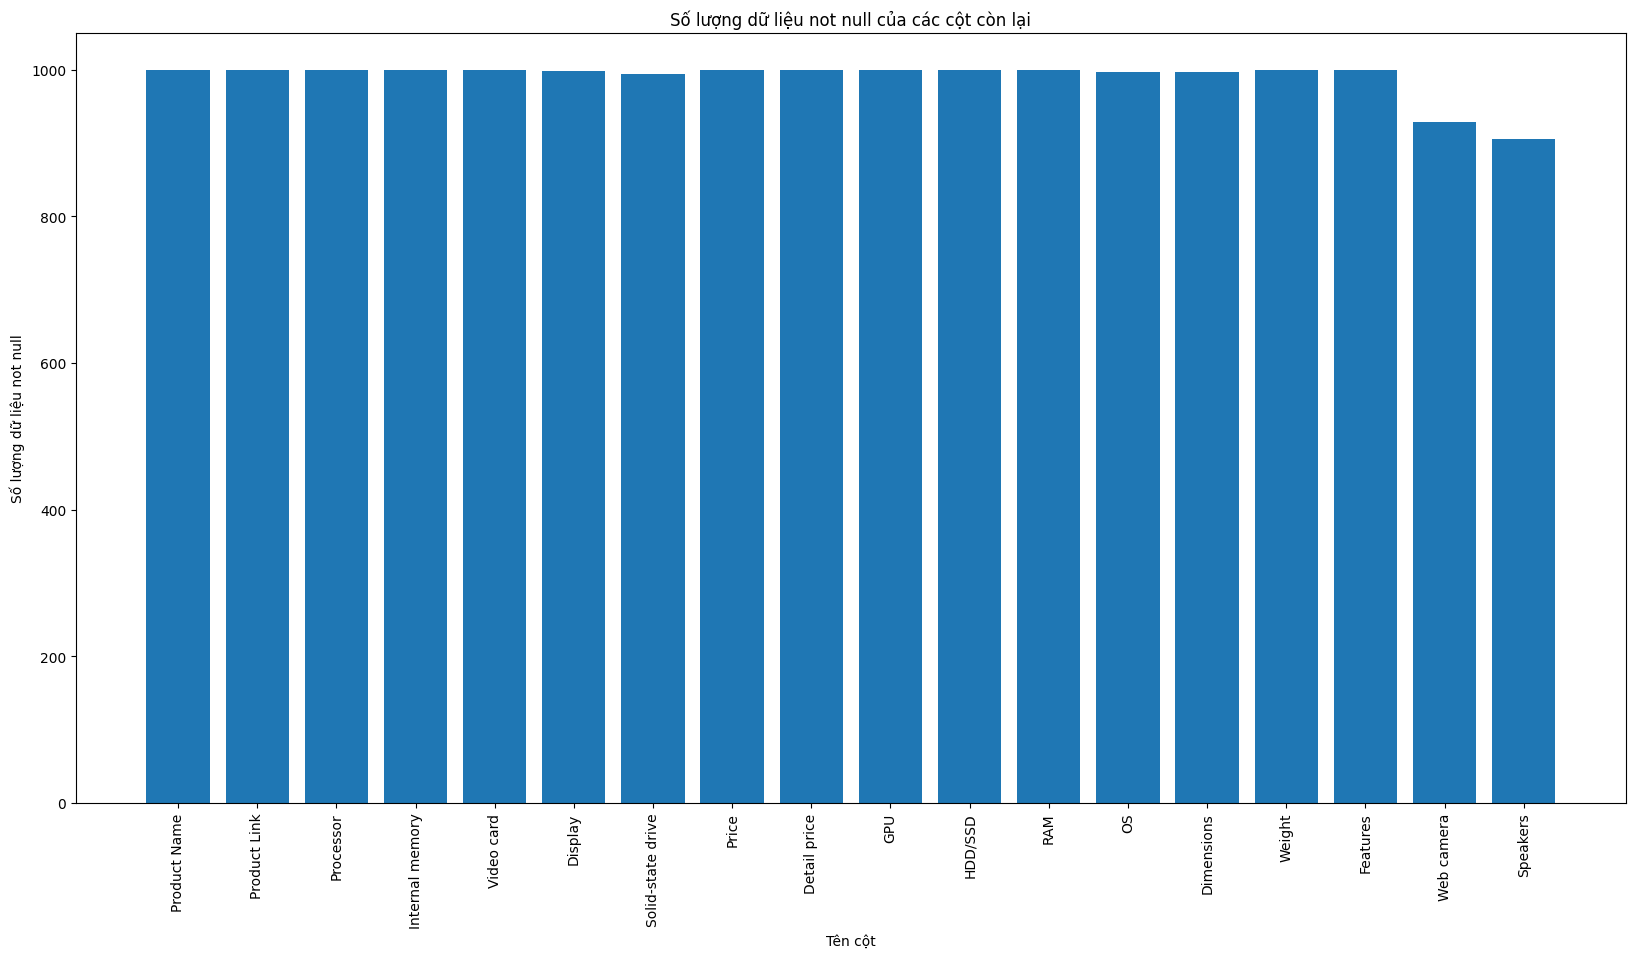

In [13]:
# plot the number of non-null values of each column
plt.figure(figsize=(20, 10))
plt.bar(data.columns, data.count())
plt.xticks(rotation=90)
plt.title('Số lượng dữ liệu not null của các cột còn lại')
plt.xlabel('Tên cột')
plt.ylabel('Số lượng dữ liệu not null')
plt.show()

#### 3.2.3 Chỉnh sửa thông tin và xóa đi các cột thông tin không cần thiết/ trùng lặp

- Giữ lại cột 'Solid-state-drive' vì dữ liệu dễ xử lý và sạch hơn cột 'HDD/SSD'. Cột 'HDD/SSD' có nhiều dữ liệu không đồng nhất do đó ta xóa cột này đi.

In [14]:
data['HDD/SSD'].unique()[:25]

array(['1TB SSD', '512GB SSD', '128GB SSD', '4TB SSD', '2TB SSD',
       '64GB eMMC', '1TB SSD ', '8TB SSD', '256GB SSD', '1TB SSD RAID 0',
       '2TB SSD  + 2TB HDD', '4TB SSD RAID 0', '256GB SSD + 1TB HDD',
       '2TB SSD RAID 0', '2TB SSD ', '516GB SSD', '512GB SSD RAID 1',
       '512GB SSD + 1TB HDD', '512GB PCIe SSD', '500GB HDD, 7200 rpm',
       '32GB eMMC', '256GB SSD + 2TB HDD', '4TB SSD RAID 1',
       '8TB SSD RAID 0', '8TB SSD RAID 1'], dtype=object)

In [15]:
data = data.drop(columns='HDD/SSD')

- Đối với giá sản phẩm sẽ chỉ giữ lại cột 'Detail price' vì cột này có định dạng giá đúng. Do đó ta xóa cột price đi.


In [16]:
data = data.drop(columns='Price')

- Đối với 'RAM' và 'Internal memory' sẽ giữ lại cột 'RAM' vì định dạng dữ liệu đơn giản hơn. Do đó ta xóa cột 'Internal memory' đi.


In [17]:
data = data.drop(columns='Internal memory')

- Giữ lại cột 'Video card' vì định dạng dữ liệu đơn giản hơn cột 'GPU'.

In [18]:
data = data.drop(columns='GPU')

- Cột 'Web camera' và 'Speakers' không có nhiều thông tin (chỉ có thông tin về tên của camera và loa) nên sẽ xóa.


In [19]:
# Some web camera values
data['Web camera'].unique()[10:25]

array(['HD IR with Windows Hello',
       'HD TrueVision with temporal noise reduction', 'FullHD + IR',
       'HD IR', 'HD with temporal noise reduction',
       'FHD IR, fixed focus, with ToF sensor',
       'FHD with privacy shutter, fixed focus', 'HD (720p@30FPS)',
       '720p HD (66 degrees)', 'HD 720p', 'VGA', 'FHD IR',
       'HD 720p, low light sensitive, face tracking, fixed focus',
       'HP True Vision 5MP IR ', 'HD + FHD'], dtype=object)

In [20]:
# Some speaker values
data['Speakers'].unique()[10:25]

array(['Rotating Sound Bar with Dolby Atmos',
       'Stereo Speakers, Bang & Olufsen, DTS:X Ultra',
       '2x 2W Stereo Speakers, Nahimic 3',
       '2x Stereo Speakers, Dolby Atmos', '2x 2W Nahimic 3 ',
       '2x 2W Tweeters + 2x 2W Woofers Stereo Speakers',
       '2x 2W Tweeters + 2x 2W dual-force Woofers, Smart Amp, Dolby Atmos',
       '4x Speakers, Smart Amp, Dolby Atmos',
       '4 Speakers, Bang & Olufsen',
       '2x Stereo Speakers, Smart Amp, Dolby Atmos',
       'Speakers by SonicMaster', '2x 2.5W Stereo Speakers',
       'Stereo Speakers', '2x 2W, Dolby Audio ',
       '2x Speakers, Smart Amp, Dolby Atmos'], dtype=object)

In [21]:
data = data.drop(columns=['Web camera', 'Speakers'])


- Cuối cùng, xóa cột 'Product Link' vì không cần thiết.


In [22]:
data = data.drop(columns='Product Link')


### 3.3 Kiểm tra lại tập dữ liệu


In [23]:
data.head(5)

,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features
0,ASUS ROG Zephyrus G14,AMD Ryzen 9 5900HS,"NVIDIA GeForce RTX 3050 Ti (Laptop, 75W)","14.0″, WQHD (2560 x 1440), 120 Hz, IPS",1000GB SSD,$1559.00,24GB DDR4,Windows 10 Home,"324 x 222 x 17.9 ~ 19.9 mm (12.76"" x 8.74"" x 0...",1.60 kg (3.5 lbs),Fingerprint reader
1,Lenovo ThinkPad T16 Gen 1,Intel Core i7-1260P,Intel Iris Xe Graphics G7 (96EU),"16.0”, WUXGA (1920 x 1200), IPS",512GB SSD,$1169.95,16GB DDR4,Windows 10 Pro,"361.9 x 255.5 x 20.5 - 21.1 mm (14.25"" x 10.06...",1.65 kg (3.6 lbs),Fingerprint reader
2,HP 15,Intel Core i7-1165G7,Intel Iris Xe Graphics G7 (96EU),"15.6”, Full HD (1920 x 1080), IPS",1000GB SSD,$1149.00,32GB DDR4,Windows 10 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Fingerprint reader
3,Lenovo Ideapad Flex 5 Chromebook 13,Intel Core i3-1115G4,Intel UHD Graphics Xe G4 (48EU),"13.3”, Full HD (1920 x 1080), IPS",128GB SSD,$419.00,8GB DDR4,Chrome OS,"310 x 214 x 16.95 mm (12.20"" x 8.43"" x 0.67"")",1.35 kg (3 lbs),Web camera
4,MSI Katana GF66,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",4000GB SSD,$1979.99,16GB DDR4,Windows 10 Pro,"359 x 259 x 24.9 mm (14.13"" x 10.20"" x 0.98"")",2.25 kg (5 lbs),Fingerprint reader


In [24]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Product Name       1000 non-null   object
 1   Processor          1000 non-null   object
 2   Video card         1000 non-null   object
 3   Display            998 non-null    object
 4   Solid-state drive  994 non-null    object
 5   Detail price       1000 non-null   object
 6   RAM                1000 non-null   object
 7   OS                 997 non-null    object
 8   Dimensions         996 non-null    object
 9   Weight             1000 non-null   object
 10  Features           1000 non-null   object
dtypes: object(11)
memory usage: 86.1+ KB


## 4. Gộp và chỉnh sửa lại dữ liệu (định dạng, thông tin, đơn vị...)


### 4.1 Gộp thông tin benchmark của CPU và GPU vào data


In [25]:
data_cpu = pd.read_csv('raw1k\cpuben.csv')
data_gpu = pd.read_csv('raw1k\gpuben.csv')

In [26]:
# Merge CPU data
data = pd.merge(data, data_cpu, left_on='Processor',
                right_on='CPU', how='left')
data.rename(columns={'Rank': 'Rank CPU'}, inplace=True)


In [27]:
data = pd.merge(data, data_gpu, left_on='Video card',
                right_on='GPU', how='left')
data.rename(columns={'Rank': 'Rank GPU'}, inplace=True)


In [28]:
data.head()


,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features,Rank CPU,CPU,Cinebench23,Rank GPU,GPU,3DMark Time Spy (G)
0,ASUS ROG Zephyrus G14,AMD Ryzen 9 5900HS,"NVIDIA GeForce RTX 3050 Ti (Laptop, 75W)","14.0″, WQHD (2560 x 1440), 120 Hz, IPS",1000GB SSD,$1559.00,24GB DDR4,Windows 10 Home,"324 x 222 x 17.9 ~ 19.9 mm (12.76"" x 8.74"" x 0...",1.60 kg (3.5 lbs),Fingerprint reader,30.0,AMD Ryzen 9 5900HS,13179.0,55.0,"NVIDIA GeForce RTX 3050 Ti (Laptop, 75W)",5970.0
1,Lenovo ThinkPad T16 Gen 1,Intel Core i7-1260P,Intel Iris Xe Graphics G7 (96EU),"16.0”, WUXGA (1920 x 1200), IPS",512GB SSD,$1169.95,16GB DDR4,Windows 10 Pro,"361.9 x 255.5 x 20.5 - 21.1 mm (14.25"" x 10.06...",1.65 kg (3.6 lbs),Fingerprint reader,56.0,Intel Core i7-1260P,9933.0,107.0,Intel Iris Xe Graphics G7 (96EU),1435.0
2,HP 15,Intel Core i7-1165G7,Intel Iris Xe Graphics G7 (96EU),"15.6”, Full HD (1920 x 1080), IPS",1000GB SSD,$1149.00,32GB DDR4,Windows 10 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Fingerprint reader,99.0,Intel Core i7-1165G7,5125.0,107.0,Intel Iris Xe Graphics G7 (96EU),1435.0
3,Lenovo Ideapad Flex 5 Chromebook 13,Intel Core i3-1115G4,Intel UHD Graphics Xe G4 (48EU),"13.3”, Full HD (1920 x 1080), IPS",128GB SSD,$419.00,8GB DDR4,Chrome OS,"310 x 214 x 16.95 mm (12.20"" x 8.43"" x 0.67"")",1.35 kg (3 lbs),Web camera,109.0,Intel Core i3-1115G4,3056.0,NaN,NaN,NaN
4,MSI Katana GF66,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",4000GB SSD,$1979.99,16GB DDR4,Windows 10 Pro,"359 x 259 x 24.9 mm (14.13"" x 10.20"" x 0.98"")",2.25 kg (5 lbs),Fingerprint reader,17.0,Intel Core i7-12700H,15486.0,39.0,"NVIDIA GeForce RTX 3060 (Laptop, 105W)",8290.0


Chúng ta có thể thấy rằng có một số CPU và GPU trong data không có dữ liệu. Vì vậy, chúng ta sẽ loại bỏ hai cột này khỏi data vì thông tin tương tự đã có trong cột 'Video card' và 'Processor'.


In [29]:
# Delete Processor and Video card columns
data = data.drop(columns=['CPU', 'GPU'])
data.head()


,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features,Rank CPU,Cinebench23,Rank GPU,3DMark Time Spy (G)
0,ASUS ROG Zephyrus G14,AMD Ryzen 9 5900HS,"NVIDIA GeForce RTX 3050 Ti (Laptop, 75W)","14.0″, WQHD (2560 x 1440), 120 Hz, IPS",1000GB SSD,$1559.00,24GB DDR4,Windows 10 Home,"324 x 222 x 17.9 ~ 19.9 mm (12.76"" x 8.74"" x 0...",1.60 kg (3.5 lbs),Fingerprint reader,30.0,13179.0,55.0,5970.0
1,Lenovo ThinkPad T16 Gen 1,Intel Core i7-1260P,Intel Iris Xe Graphics G7 (96EU),"16.0”, WUXGA (1920 x 1200), IPS",512GB SSD,$1169.95,16GB DDR4,Windows 10 Pro,"361.9 x 255.5 x 20.5 - 21.1 mm (14.25"" x 10.06...",1.65 kg (3.6 lbs),Fingerprint reader,56.0,9933.0,107.0,1435.0
2,HP 15,Intel Core i7-1165G7,Intel Iris Xe Graphics G7 (96EU),"15.6”, Full HD (1920 x 1080), IPS",1000GB SSD,$1149.00,32GB DDR4,Windows 10 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Fingerprint reader,99.0,5125.0,107.0,1435.0
3,Lenovo Ideapad Flex 5 Chromebook 13,Intel Core i3-1115G4,Intel UHD Graphics Xe G4 (48EU),"13.3”, Full HD (1920 x 1080), IPS",128GB SSD,$419.00,8GB DDR4,Chrome OS,"310 x 214 x 16.95 mm (12.20"" x 8.43"" x 0.67"")",1.35 kg (3 lbs),Web camera,109.0,3056.0,NaN,NaN
4,MSI Katana GF66,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",4000GB SSD,$1979.99,16GB DDR4,Windows 10 Pro,"359 x 259 x 24.9 mm (14.13"" x 10.20"" x 0.98"")",2.25 kg (5 lbs),Fingerprint reader,17.0,15486.0,39.0,8290.0


### 4.2 Xóa dữ liệu trống và trùng lặp


- Ta sẽ xóa các hàng có giá trị null trong nhiều hơn 3 cột để đảm bảo dữ liệu mang đầy đủ thông tin cho quá trình xử lý về sau

In [30]:
# print number of rows that have missing values in more than 5 columns
print('Number of rows that have missing values in more than 3 columns:', data[data.isnull().sum(axis=1) > 3].shape[0])

Number of rows that have missing values in more than 3 columns: 30


In [31]:
# delete rows that have null values in more than 3 columns
data = data.dropna(thresh=data.shape[1] - 3)

- Xóa các dòng dữ liệu trùng lặp

In [32]:
data.drop_duplicates(inplace=True)
data = data.reset_index(drop=True)

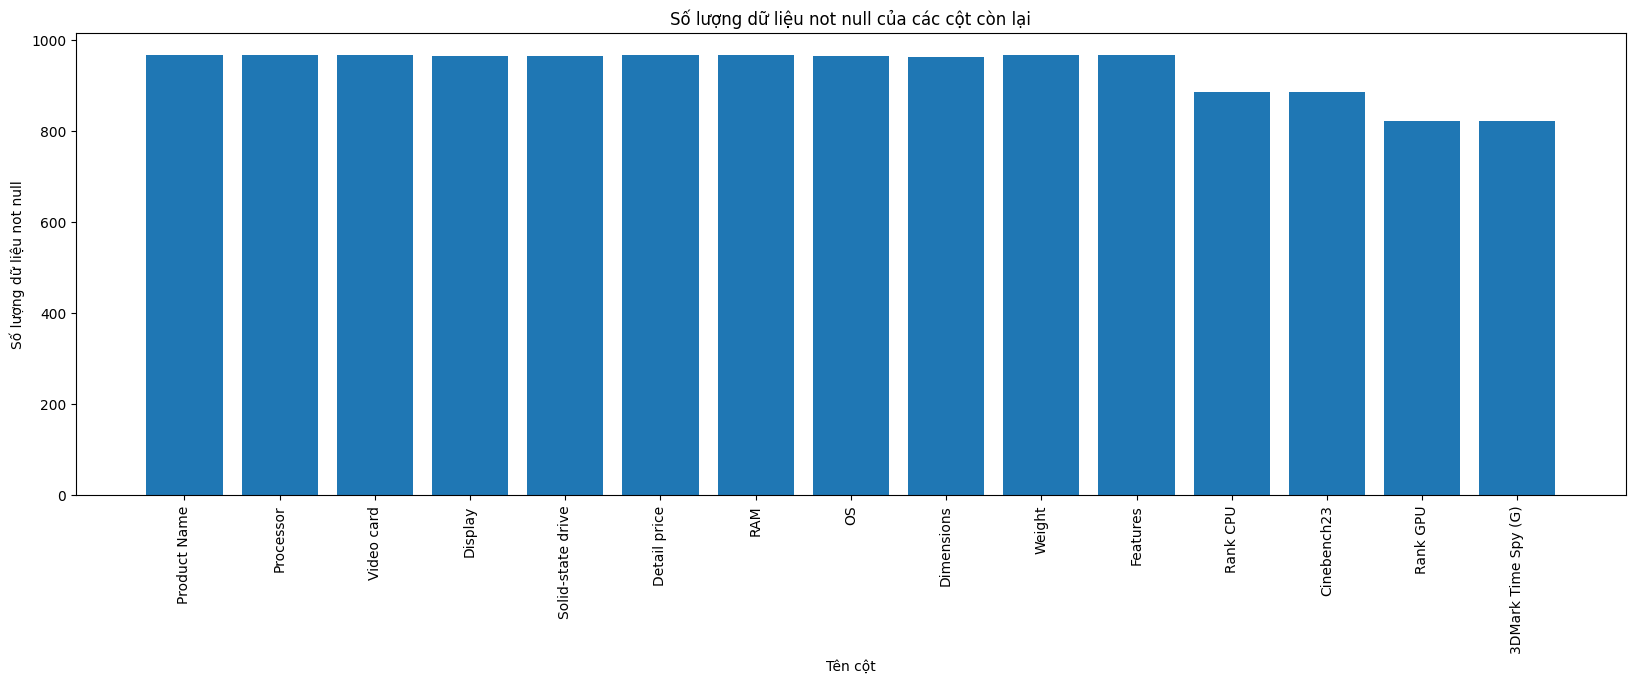

In [33]:
# print the sorted number of non-null values of each column
# plot the number of non-null values of each column
plt.figure(figsize=(20, 6))
plt.bar(data.columns, data.count())
plt.xticks(rotation=90)
plt.title('Số lượng dữ liệu not null của các cột còn lại')
plt.xlabel('Tên cột')
plt.ylabel('Số lượng dữ liệu not null')
plt.show()


In [34]:
data.head()


,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features,Rank CPU,Cinebench23,Rank GPU,3DMark Time Spy (G)
0,ASUS ROG Zephyrus G14,AMD Ryzen 9 5900HS,"NVIDIA GeForce RTX 3050 Ti (Laptop, 75W)","14.0″, WQHD (2560 x 1440), 120 Hz, IPS",1000GB SSD,$1559.00,24GB DDR4,Windows 10 Home,"324 x 222 x 17.9 ~ 19.9 mm (12.76"" x 8.74"" x 0...",1.60 kg (3.5 lbs),Fingerprint reader,30.0,13179.0,55.0,5970.0
1,Lenovo ThinkPad T16 Gen 1,Intel Core i7-1260P,Intel Iris Xe Graphics G7 (96EU),"16.0”, WUXGA (1920 x 1200), IPS",512GB SSD,$1169.95,16GB DDR4,Windows 10 Pro,"361.9 x 255.5 x 20.5 - 21.1 mm (14.25"" x 10.06...",1.65 kg (3.6 lbs),Fingerprint reader,56.0,9933.0,107.0,1435.0
2,HP 15,Intel Core i7-1165G7,Intel Iris Xe Graphics G7 (96EU),"15.6”, Full HD (1920 x 1080), IPS",1000GB SSD,$1149.00,32GB DDR4,Windows 10 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Fingerprint reader,99.0,5125.0,107.0,1435.0
3,Lenovo Ideapad Flex 5 Chromebook 13,Intel Core i3-1115G4,Intel UHD Graphics Xe G4 (48EU),"13.3”, Full HD (1920 x 1080), IPS",128GB SSD,$419.00,8GB DDR4,Chrome OS,"310 x 214 x 16.95 mm (12.20"" x 8.43"" x 0.67"")",1.35 kg (3 lbs),Web camera,109.0,3056.0,NaN,NaN
4,MSI Katana GF66,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",4000GB SSD,$1979.99,16GB DDR4,Windows 10 Pro,"359 x 259 x 24.9 mm (14.13"" x 10.20"" x 0.98"")",2.25 kg (5 lbs),Fingerprint reader,17.0,15486.0,39.0,8290.0


### 4.3 Chỉnh sửa lại các cột dữ liệu


- Tạo một dataframe mới để chứa dữ liệu sau khi làm sạch

In [35]:
# create new dataframe
clean_df = pd.DataFrame()

#### 4.3.1 Chỉnh sửa thông tin giá

- **Price** : giá laptop (đơn vị: USD) là thông tin được sử dụng để dự đoán. Ta chỉ giữ lại giá trị và xóa kí tự $.

In [36]:
clean_df['price'] = data['Detail price'].str.extract(r'\$(\d+.\d+)')
clean_df['price'] = clean_df['price'].astype('float64')


#### 4.3.2 Chỉnh sửa thông tin hãng sản xuất

- **Brand** : Laptop brand
- Trích xuất tên hãng từ cột 'Product Name'.


In [37]:
clean_df['brand'] = data['Product Name'].str.upper().str.split().str[0]
clean_df['brand'].unique()

array(['ASUS', 'LENOVO', 'HP', 'MSI', 'DELL', 'ALIENWARE', 'ACER', 'LG',
       'AORUS', 'DYNABOOK', 'APPLE', 'PANASONIC', 'MICROSOFT', 'GIGABYTE'],
      dtype=object)

#### 4.3.3 Chỉnh sửa thông tin RAM

- **RAM** : Laptop RAM
- Trích xuất thông tin về dung lượng RAM từ cột 'RAM'.


In [38]:
clean_df['ram'] = data['RAM'].str.upper().str.extract(r'(\d+)\s*GB')
clean_df['ram'] = clean_df['ram'].astype('float64')
clean_df['ram'].unique()


array([ 24.,  16.,  32.,   8.,  64.,  36.,   4.,  20.,  40.,  48.,  12.,
       128.])

- **RAM TYPE** : Loại RAM
- Trích xuất thông tin về loại RAM từ cột 'RAM'.


In [39]:

clean_df['ram_type'] = data['RAM'].str.upper().str.extract(r'(\d+)\s*GB')
# get text after GB and before , (comma) or nothing
clean_df['ram_type'] = data['RAM'].str.upper().str.extract(r'GB\s*(\w*)\,?')
# print numver of non-null value
clean_df['ram_type'].unique()


array(['DDR4', 'DDR5', 'LPDDR4X', 'LPDDR5', 'LPDDR4', 'LPDDR3', 'RAM'],
      dtype=object)

In [40]:
clean_df['ram_type'].value_counts()

ram_type
DDR4       713
DDR5       188
LPDDR5      33
LPDDR4X     26
RAM          3
LPDDR4       2
LPDDR3       1
Name: count, dtype: int64

Ta thấy không có loại ram nào có tên loại là RAM, điều này có thể vì dữ liệu cào không sạch, ta thấy số record có 'ram_type' là 'RAM' là 1. Vì vậy, ta sẽ xóa các record này.

In [41]:
# delete rows with ram_type is 'RAM'
clean_df = clean_df[clean_df['ram_type'] != 'RAM']

#### 4.3.4 Chỉnh sửa thông tin về màn hình laptop

- **Display Resolution** : Laptop display resolution
- Từ các dòng dữ liệu: "15.6”, Full HD (1920 x 1080), 144 Hz, IPS" trong cột 'Display' ta trích xuất ra thêm các thuộc tính: 
    - **'display_size'** : Kích thước màn hình laptop (inch)
    - **'display_type'** : Loại màn hình laptop (HD, Full HD, 4K, OLED, ...)
    - **'screen_rate'** : Tần số làm tươi màn hình laptop (Hz)
    - **'screen_panel'** : Loại panel màn hình laptop (IPS, TN, OLED, ...)


In [42]:
# tìm kiếm kích thước màn hình
clean_df['display_size'] = data['Display'].str.extract(r'^(\d+\.?\d+)')
clean_df['display_size'] = clean_df['display_size'].astype('float64')

clean_df['display_type'] = data['Display'].str.extract(r'[,](.*?)[(]')

clean_df['resolution'] = data['Display'].str.extract(r'\((.*?)\)')

clean_df['screen_rate'] = data['Display'].str.extract(r'[)][,](.*?)[H]')

clean_df['screen_panel'] = data['Display'].str.split(',').str[-1]
# remove space at the beginning and end of the string
clean_df['screen_panel'] = clean_df['screen_panel'].str.strip()


In [43]:
# print unique value of screen_panel
clean_df['screen_panel'].value_counts()

screen_panel
IPS                         786
TN                          155
OLED                         20
PixelSense (2256 x 1504)      1
Name: count, dtype: int64

In [44]:
clean_df['screen_panel'].unique()

array(['IPS', 'TN', 'OLED', 'PixelSense (2256 x 1504)', nan], dtype=object)

Ta thấy một số record PixelSense (2256 x 1504) Full HD (1920 x 1080) ở đây, có nghĩa là những dòng này trong dữ liệu gốc không có dữ liệu về tấm nên, do đó ta xóa các record này đi

In [45]:
# delete rows with screen_panel is 'PixelSense (2256 x 1504)'
clean_df = clean_df[clean_df['screen_panel'] != 'PixelSense (2256 x 1504)']
# delete rows with screen_panel is 'Full HD (1920 x 1080)'
clean_df = clean_df[clean_df['screen_panel'] != 'Full HD (1920 x 1080)']

- Loại bỏ khoảng trắng trong cột 'screen_rate' và chuyển đổi sang kiểu số.

In [46]:
clean_df['screen_rate'] = clean_df['screen_rate'].str.strip()
clean_df['screen_rate'] = clean_df['screen_rate'].astype('float64')
clean_df['screen_rate'].unique()


array([120.,  nan, 144., 165., 240., 360.,  90., 300.])

In [47]:
clean_df['display_type'].unique()

array([' WQHD ', ' WUXGA ', ' Full HD ', ' HD ', ' WQXGA ', ' UHD+ ',
       ' HD+ ', ' WUXGA+ ', ' QHD ', ' WQUXGA ', ' QHD+ ', ' 2.8K ',
       ' 4K UHD ', ' 2.2K ', ' FHD+ ', ' 3K ', '  QHD ', ' 2.5K ',
       ' FHD ', nan, ' 3.5K ', ' 2K '], dtype=object)

Chúng ta có thể thấy cột display_type chưa được loại bỏ khoảng trắng và ký tự đặc biệt. Vì vậy, chúng ta sẽ loại bỏ khoảng trắng và ký tự đặc biệt trong cột này. \xa0 = space

In [48]:
# trim space before and after string in display_type
clean_df['display_type'] = clean_df['display_type'].str.strip()
# change value 'Full HD' to 'FHD'
clean_df['display_type'] = clean_df['display_type'].str.replace('Full HD', 'FHD')
clean_df['display_type'].unique()


array(['WQHD', 'WUXGA', 'FHD', 'HD', 'WQXGA', 'UHD+', 'HD+', 'WUXGA+',
       'QHD', 'WQUXGA', 'QHD+', '2.8K', '4K UHD', '2.2K', 'FHD+', '3K',
       '2.5K', nan, '3.5K', '2K'], dtype=object)

#### 4.3.5 Chỉnh sửa thông tin về kích thước laptop

- **Dimmension** : 358.9 x 228 x 18.4 mm -> kích thước của laptop bao gồm chiều dài, chiều rộng và độ dày (mm)


In [49]:
dimention = data['Dimensions'].str.findall(r'(\d+\.?\d+)')
# clean_df['length'] the first number in dimention
clean_df['length'] = dimention.str[0]
# clean_df['width'] the second number in dimention
clean_df['width'] = dimention.str[1]
# clean_df['height'] the third number in dimention
clean_df['thickness'] = dimention.str[2]


In [50]:
# convert to float
clean_df['length'] = clean_df['length'].astype('float64')
clean_df['width'] = clean_df['width'].astype('float64')
clean_df['thickness'] = clean_df['thickness'].astype('float64')

#### 4.3.6 Chỉnh sửa thông tin về hãng CPU và GPU

- **Processor** : CPU of laptop
- Ta trích xuất thông tin hãng sản xuất CPU và GPU từ cột 'Processor' và 'Video card'.


In [51]:
clean_df['cpu_brand'] = data['Processor'].str.split().str[0]
clean_df['cpu_brand'].unique()


array(['AMD', 'Intel'], dtype=object)

- **GPU** : Laptop graphic card


In [52]:
clean_df['gpu_brand'] = data['Video card'].str.upper().str.split().str[0]
clean_df['gpu_brand'].unique()


array(['NVIDIA', 'INTEL', 'AMD'], dtype=object)

#### 4.3.7 Chỉnh sửa thông tin về bộ nhớ trong SSD và HDD

- **Bộ nhớ trong SSD**
- Ta trích xuất dung lượng bộ nhớ trong từ cột SSD.


In [53]:
clean_df['ssd'] = data['Solid-state drive'].str.extract(r'(\d+)\s*GB')
clean_df['ssd'] = clean_df['ssd'].astype('float64')
clean_df['ssd'].unique()


array([1000.,  512.,  128., 4000., 2000.,   64., 8000.,  256.,  516.,
         32.,   nan,  120., 7600.])

#### 4.3.8 Chỉnh sửa thông tin về hệ điều hành

- **OS**
- Ta trích xuất thông tin về hệ điều hành từ cột OS


In [54]:
clean_df['os'] = data['OS'].str.extract(
    r'(Windows|Linux|No OS|Mac OS|Chrome OS)')

#### 4.3.9 Chỉnh sửa thông tin về cân nặng laptop

- **Weights**
- Ta trích xuất cân nặng của laptop theo đơn vị Kg.


In [55]:
clean_df['weight'] = data['Weight'].str.extract(r'^(\d+\.?\d+)')
clean_df['weight'] = clean_df['weight'].astype('float64')

#### 4.3.10 Chỉnh sửa thông tin về xếp hạng và điểm hiệu năng của CPU và GPU

- CPU/ GPU benchmark
- Ta đổi tên cột và chuyển dữ liệu sang kiểu float 64

In [56]:
clean_df['cpu_point'] = data['Cinebench23']
clean_df['gpu_point'] = data['3DMark Time Spy (G)']

# convert to float
clean_df['cpu_point'] = clean_df['cpu_point'].astype('float64')
clean_df['gpu_point'] = clean_df['gpu_point'].astype('float64')


#### 4.3.11 Chỉnh sửa thông tin về các chức năng khác của laptop

- **Features**
- Cột features chứa các tính năng khác của laptop, do đó ta không cần chỉnh sửa

In [57]:
clean_df['features'] = data['Features']
clean_df['features'].value_counts()


features
Fingerprint reader    786
Web camera            175
Microphone              1
Name: count, dtype: int64

#### 4.3.12 Chỉnh sửa các cột dữ liệu dạng string thành uppercase

- Để dữ liệu được đồng bộ, ta sẽ chuyển các cột dữ liệu dạng string thành uppercase

In [58]:
# conver brand, ram_type, display_type, screen_panel, cpu_brand, gpu_brand, OS to uppercase
clean_df['brand'] = clean_df['brand'].str.upper()
clean_df['ram_type'] = clean_df['ram_type'].str.upper()
clean_df['display_type'] = clean_df['display_type'].str.upper()
clean_df['screen_panel'] = clean_df['screen_panel'].str.upper()
clean_df['cpu_brand'] = clean_df['cpu_brand'].str.upper()
clean_df['gpu_brand'] = clean_df['gpu_brand'].str.upper()
clean_df['os'] = clean_df['os'].str.upper()
clean_df['features'] = clean_df['features'].str.upper()


#### 4.3.13 Xóa dữ liệu trống và trùng lặp một lần nữa

- Vì chúng ta tiến hành dự đoán giá laptop, do đó, chúng ta sẽ xóa các dòng dữ liệu có giá trị 'Price' là NaN.
- Sau đó xóa các dòng trùng lặp thông tin và reset lại index

In [59]:
# drop missing value in Price column
clean_df.dropna(subset=['price'], inplace=True)

# clean_df.dropna(inplace=True)
clean_df.drop_duplicates(inplace=True)
# reset index column
clean_df.reset_index(drop=True, inplace=True)


## 5. Kiểm tra lại và lưu dữ liệu

In [60]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         947 non-null    float64
 1   brand         947 non-null    object 
 2   ram           947 non-null    float64
 3   ram_type      947 non-null    object 
 4   display_size  946 non-null    float64
 5   display_type  946 non-null    object 
 6   resolution    946 non-null    object 
 7   screen_rate   321 non-null    float64
 8   screen_panel  946 non-null    object 
 9   length        943 non-null    float64
 10  width         943 non-null    float64
 11  thickness     943 non-null    float64
 12  cpu_brand     947 non-null    object 
 13  gpu_brand     947 non-null    object 
 14  ssd           944 non-null    float64
 15  os            944 non-null    object 
 16  weight        947 non-null    float64
 17  cpu_point     869 non-null    float64
 18  gpu_point     807 non-null    

In [61]:
clean_df.head()


,price,brand,ram,ram_type,display_size,display_type,resolution,screen_rate,screen_panel,length,width,thickness,cpu_brand,gpu_brand,ssd,os,weight,cpu_point,gpu_point,features
0,1559.00,ASUS,24.0,DDR4,14.0,WQHD,2560 x 1440,120.0,IPS,324.0,222.0,17.90,AMD,NVIDIA,1000.0,WINDOWS,1.60,13179.0,5970.0,FINGERPRINT READER
1,1169.95,LENOVO,16.0,DDR4,16.0,WUXGA,1920 x 1200,NaN,IPS,361.9,255.5,20.50,INTEL,INTEL,512.0,WINDOWS,1.65,9933.0,1435.0,FINGERPRINT READER
2,1149.00,HP,32.0,DDR4,15.6,FHD,1920 x 1080,NaN,IPS,358.0,242.0,17.90,INTEL,INTEL,1000.0,WINDOWS,1.70,5125.0,1435.0,FINGERPRINT READER
3,419.00,LENOVO,8.0,DDR4,13.3,FHD,1920 x 1080,NaN,IPS,310.0,214.0,16.95,INTEL,INTEL,128.0,CHROME OS,1.35,3056.0,NaN,WEB CAMERA
4,1979.99,MSI,16.0,DDR4,15.6,FHD,1920 x 1080,144.0,IPS,359.0,259.0,24.90,INTEL,NVIDIA,4000.0,WINDOWS,2.25,15486.0,8290.0,FINGERPRINT READER


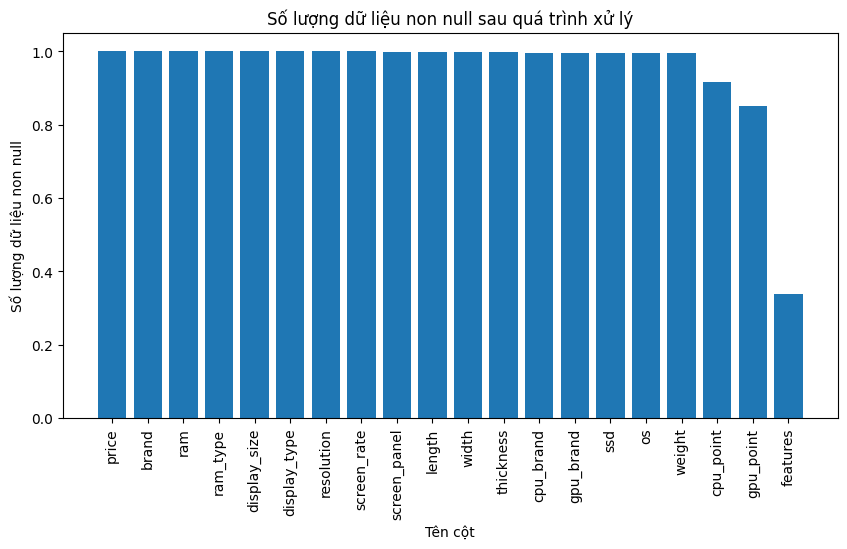

In [62]:
# plot bar chart of number of non-null value in each column
plt.figure(figsize=(10, 5))
# plot percentage of non-null value in each column and sort by value ascending
plt.bar(clean_df.columns, clean_df.notnull().mean().sort_values(ascending=False))
plt.xticks(rotation=90)
plt.title('Số lượng dữ liệu non null sau quá trình xử lý')
plt.xlabel('Tên cột')
plt.ylabel('Số lượng dữ liệu non null')
plt.show()


- Lưu lại dữ liệu đã làm sạch

In [63]:
clean_df.to_csv('clean_data_1k.csv', index=False)
